<a href="https://colab.research.google.com/github/Seanabuklau/CL_Project_Experience/blob/main/is483_project_experience.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Retrieval-Augmented Generation

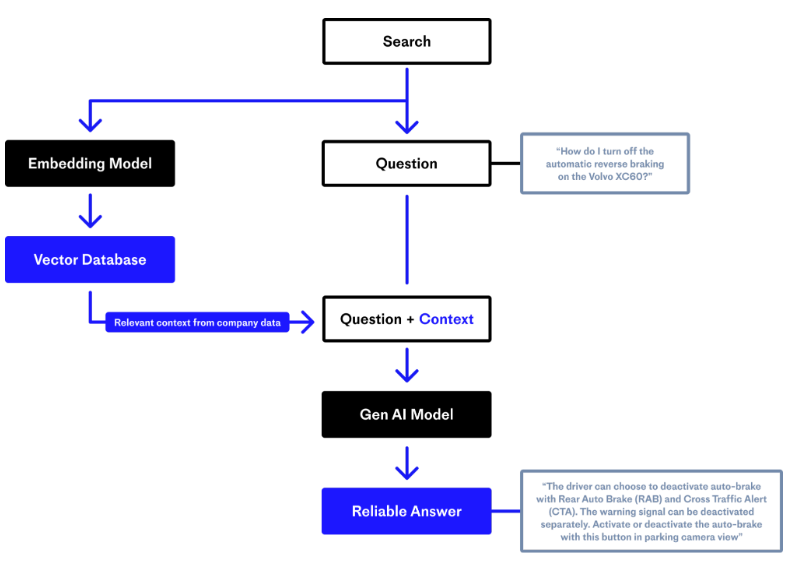

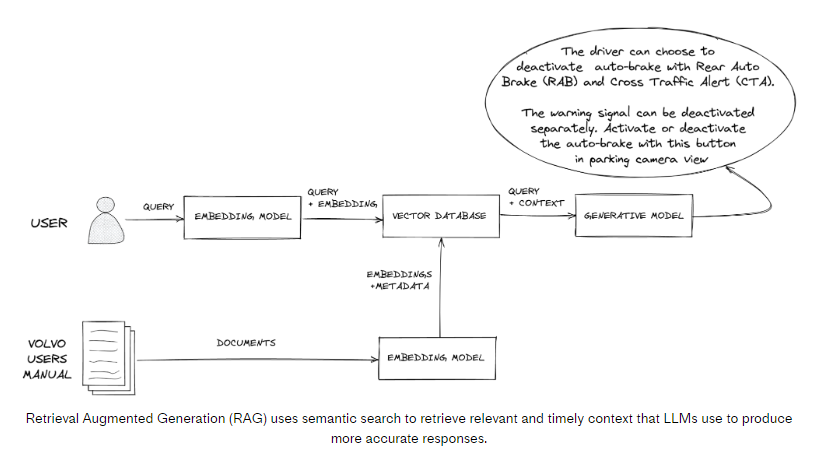

**Download and load all requisite libraries**

In [ ]:
!pip install langchain -q
!pip install openai -q
!pip install "shapely==1.8.5" -q
!pip install google-cloud-aiplatform --upgrade -q
!pip install unstructured[all-docs] -q
!pip install tiktoken -q
!pip install sentence_transformers -q
!pip install pinecone-client -q
!pip install pypdf -q
!pip install PyPDF2 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.0/321.0 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.1/275.1 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 50.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 7.9 MB/s eta 0:00:0

In [ ]:
import pinecone
import vertexai
import langchain
import PyPDF2

/usr/local/lib/python3.10/dist-packages/pinecone/index.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


**Parse Corpus**

In [ ]:
from langchain.document_loaders import UnstructuredPDFLoader, OnlinePDFLoader

# Load corpus
loader2 = UnstructuredPDFLoader("./Misuse of Drugs Act 1973.pdf")
docs2 = loader2.load()

In [ ]:
from langchain.document_loaders import UnstructuredPDFLoader, OnlinePDFLoader

# Load corpus
loader1 = UnstructuredPDFLoader("./MDA cases.pdf")
docs1 = loader1.load()

**Chunk Corpus**

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter


text_splitter1 = RecursiveCharacterTextSplitter(chunk_size=10000, chunk_overlap=0)
text_splitter2 = RecursiveCharacterTextSplitter(chunk_size=5000, chunk_overlap=0)

# Chunk docs
chunks_docs1 = text_splitter1.split_documents(docs1)
chunks_docs2 = text_splitter2.split_documents(docs2)

**Embedding Models**

*OpenAI Embedder*

In [ ]:
from langchain.vectorstores import Pinecone
from langchain.embeddings.openai import OpenAIEmbeddings

API_KEY = "OPENAI_EMBEDDER_API"

embeddings = OpenAIEmbeddings(openai_api_key = API_KEY)

*MPNet Embedder*

In [ ]:
from langchain.embeddings import HuggingFaceEmbeddings, SentenceTransformerEmbeddings
from sentence_transformers import SentenceTransformer

# Load the embedding model
embeddings = HuggingFaceEmbeddings(model_name="all-mpnet-base-v2")

**Load Embeddings into Vector Database Pinecone**

In [ ]:
from langchain.vectorstores import Pinecone

API_KEY = "PINECONE_API"

# Initialise Pinecone instance
pinecone.init(api_key=API_KEY,
              environment="gcp-starter")

# Define index
index_name = "prod-index-1"

# First, check if our index already exists. If it doesn't, we create it
if index_name not in pinecone.list_indexes():
    # we create a new index
    index = pinecone.create_index(
              name=index_name,
              metric='cosine',
              dimension=768
            )

docsearch1 = Pinecone.from_texts([t.page_content for t in chunks_docs1], embeddings, index_name=index_name)

In [ ]:
docsearch2 = Pinecone.from_texts([t.page_content for t in chunks_docs2], embeddings, index_name=index_name)

**Doc Search**

In [ ]:
query = "trafficking"
docs = docsearch2. similarity_search(query)

**Authenticate to VertexAI in Google Cloud**

In [ ]:
from langchain.llms import VertexAI
from google.colab import auth as google_auth

google_auth.authenticate_user()
vertexai.init(project="GCP_PROJECT_ID", location="asia-southeast1")

# LLM Selection
llm = VertexAI(
    model_name="text-bison@001",
    max_output_tokens=1024,
    temperature=0.3,
    top_p=0.8,
    top_k=40,
    verbose=True,
)

**Q&A Chain**

*Method 1*

In [ ]:
from langchain.chains.question_answering import load_qa_chain

chain = load_qa_chain(llm, chain_type="stuff")
query = "What is the punishment for Trafficking Class A drugs in Singapore?"
docs = docsearch. similarity_search(query)
output = chain.run(input_documents=docs, question=query)

print("Answer: \n\n", output)

Answer: 

 The punishment for trafficking Class A drugs in Singapore is imprisonment for a term of not less than 10 years and not more than 30 years, and not less than 10 strokes and not more than 15 strokes of the cane.


**TEST**

In [ ]:
import requests
import json

# inputs
a = 'What is cannabis resin?'
b = 'What are the punishments for Exposing child to drugs, etc., and permitting young person to consume drugs?'
c = 'What are the punishments for Introducing drug trafficker to another person'
d = 'What are the punishments for abetting to Introduce a drug trafficker to another person'
e = 'What are the punishments for abetting to Expose children to drugs'

o = "What is the punishment for trafficking more than 100g of methamphetamine?"

# Set the request headers
headers = {
    'Content-Type': 'application/json'
}

# Set the request body
data = {
    'input': a
}

# API endpoints
e1 = 'https://us-central1-fyp-is483.cloudfunctions.net/function-2'
e2 = "https://us-central1-fyp-is483.cloudfunctions.net/sentencing-calculator-api-2"

# Make the POST request
response = requests.post(e2, headers=headers, data=json.dumps(data))

In [ ]:
print(response.content.decode('utf-8'))

{"status": "success", "message": "The punishment for trafficking more than 100g of methamphetamine is 10 years imprisonment, a fine of $100,000 or both."}
